# setup

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from datetime import timedelta

from warnings import filterwarnings
filterwarnings('ignore')
testing_models = True
# TODO:
# Add forecasting models that work
# use forecast instead of predict
# tune underperformers
# Determine when a forecasting model works given a time series features.



# data prep

In [2]:
data = pd.read_csv("../data/store_demand.csv")

In [3]:
data = pd.read_csv("../data/store_demand.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data['store_item'] = data.store.astype(str) + '-' + data.item.astype(str)
data.drop(['store', 'item'], axis=1, inplace=True)
# data = data[data.store_item != '3-5'] # auto reg broke on this one check it if time permits
# note non unique indices


# train test split

In [4]:
def train_test_splitter(df, pct=0.8):
    timespan = (df.index.max() - df.index.min()).days
    train_date = round(timespan*pct)
    train = df.index.min() + timedelta(days=train_date)
    return [df[df.index <= train], df[df.index > train]]


train, test = train_test_splitter(data, .7)



In [5]:
import matplotlib.pyplot as plt

%matplotlib inline


# for store in train.store_item.unique():
#     temp = train[train.store_item == store]
#     plt.figure()
#     plt.plot(temp.sales, "-b", label = "sales")
#     plt.legend(loc="upper left")
#     plt.title(f"store {store}")
#     plt.show()


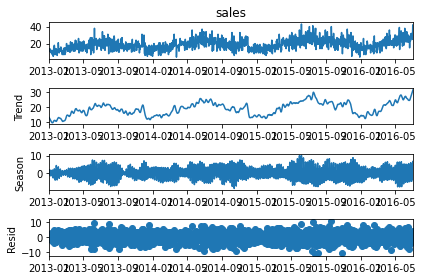

In [6]:
from statsmodels.tsa.seasonal import STL

df = train[train.store_item == "1-1"]
res = STL(df.sales).fit()
res.plot()
plt.show()

# time series feature detection

In [7]:
from tsfeatures import tsfeatures
# this function is kinda wierd it requires a df with specific names
n = 0
feature_list = []
for item in train.store_item.unique():
    
    tester = train[train.store_item == item]
    tester.reset_index(inplace=True)

    tester["unique_id"] = item
    tester.drop("store_item", axis=1, inplace=True)
    tester.rename(columns={"sales":"y", "date":"ds"}, inplace=True)

    features = tsfeatures(tester, freq=1)
    feature_list.append(features)
    n += 1
    if n > 5:
        break


arr = np.array(feature_list)
feats = arr.reshape(len(feature_list), 38)
pd.DataFrame(feats, columns=feature_list[0].columns)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,flat_spots,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10
0,1-1,0.841606,1279,-991.917409,3.146563,NaN,NaN,NaN,0.436294,0,...,6,0.744548,419,0.117548,0.433635,1.498446,-0.433396,0.294302,-0.631182,0.535604
1,2-1,0.91135,1279,-831.494587,3.310794,NaN,NaN,NaN,0.489281,0,...,7,0.712613,407,0.142211,0.502687,1.879023,-0.429875,0.234543,-0.651916,0.499956
2,3-1,0.873043,1279,-987.775958,2.905416,NaN,NaN,NaN,0.456243,0,...,5,0.723574,429,0.091336,0.442316,1.617506,-0.462695,0.314891,-0.661656,0.592635
3,4-1,0.844694,1279,-1011.330434,2.582235,NaN,NaN,NaN,0.445286,0,...,7,0.739945,429,0.102222,0.435504,1.62504,-0.469077,0.28132,-0.656254,0.520351
4,5-1,0.860274,1279,-1180.265044,2.949875,NaN,NaN,NaN,0.378891,0,...,7,0.78065,493,0.045313,0.345667,1.045886,-0.474195,0.270755,-0.667555,0.541858
5,6-1,0.872302,1279,-1159.865159,2.517493,NaN,NaN,NaN,0.387035,0,...,7,0.78684,460,0.060444,0.351075,1.044682,-0.453832,0.252476,-0.638486,0.465


# plotting series

# tune models on a subset of categories

In [8]:

# subset for testing

if testing_models:
    train = train[train.store_item.isin(['1-1', '1-2', '1-3'])]
    test = test[test.store_item.isin(['1-1', '1-2', '1-3'])]
else: 
    from warnings import filterwarnings
    filterwarnings('ignore')
    

# fitting vector autoreg

In [9]:
from statsmodels.tsa.ar_model import AutoReg

In [10]:
# generalize this a bit later, 
preds_autoreg = []
store_item = []
for series in train.store_item.unique(): 
    temp = train[train.store_item == series]
    
    model = AutoReg(temp.sales, lags=10, old_names=False, seasonal=True, period=365)
    model_fit = model.fit()
    try:
        yhat = model_fit.predict(start = test.index[0], end = test.index[-1]) # find a less ratchet way
        # to make the prediction len match the testing set len
        preds_autoreg.append(yhat)
        item = np.repeat(series, len(yhat))
        store_item.append(item)
    except np.linalg.LinAlgError:
        print(f'series {series}')

In [11]:
dates = []
for item in preds_autoreg:
    for sub in item.index:
        dates.append(sub)

In [12]:
predictions = pd.DataFrame(
    {
        'store_item': [x for sub in store_item for x in sub],
        'sales': test.sales,
        'autoreg': [x for sub in preds_autoreg for x in sub]     
    }, index = dates
)

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [14]:
def exp_smooth_predictor(seas="multiplicative"):
    exp_smooth_preds = []
    for item in train.store_item.unique():
        temp = train[train.store_item == item]
        # temp.index.freq = "d"
        preds = ExponentialSmoothing(temp.sales,     
            seasonal_periods=365,
            trend="add",
            seasonal=seas,
            use_boxcox=True,
            initialization_method="estimated")\
        .fit()\
        .predict(start = test.index[0], end = test.index[-1])
        exp_smooth_preds.append(preds)
        
    return [x for sub in exp_smooth_preds for x in sub]  

In [15]:
predictions["exp_smooth"] = exp_smooth_predictor(seas="add")
predictions["exp_smooth_multi"] = exp_smooth_predictor()

In [16]:
from statsmodels.tsa.api import ARDL

In [17]:
ardl_preds = []

for item in train.store_item.unique():
    temp = train[train.store_item == item]
    ar = ARDL(temp.sales, 365, period=365, trend="t")\
        .fit()\
        .predict(start = test.index[0], end = test.index[-1])
    ardl_preds.append(ar)
    
predictions["ardl"] = [x for sub in ardl_preds for x in sub]  

In [18]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [19]:
# https://www.youtube.com/watch?v=pOYAXv15r3A
model = Prophet()


In [55]:
forecast_h = test.index[-1] - test.index[0]


In [65]:
%%capture
prophet_preds = []
for item in train.store_item.unique():
    
    tester = train[train.store_item == item]
    tester.reset_index(inplace=True)

    tester["unique_id"] = item
    tester.drop("store_item", axis=1, inplace=True)
    tester.rename(columns={"sales":"y", "date":"ds"}, inplace=True)
    
    model = Prophet(daily_seasonality=True)
    model.fit(tester)
    pred_frame = model.make_future_dataframe(periods=forecast_h.days)
    preds = model.predict(pred_frame)
    prophet_preds.append(preds.yhat[-forecast_h.days - 1:])


Initial log joint probability = -23.8441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2304.99    0.00059656       212.127    4.31e-06       0.001      145  LS failed, Hessian reset 
      99       2305.17   0.000825136       89.4793      0.9746      0.9746      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193        2305.9    0.00037808       161.031   2.206e-06       0.001      316  LS failed, Hessian reset 
     199       2306.19    0.00069264       73.7016      0.3052           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       2306.29   4.25779e-05       86.2633   5.088e-07       0.001      415  LS failed, Hessian reset 
     271       2306.29   1.51602e-07       79.5501           1           1      452   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

In [62]:

predictions["prophet"] = [x for sub in prophet_preds for x in sub] 

In [1]:
import pmdarima as pm

# https://pypi.org/project/pmdarima/

In [ ]:
mod = SARIMAX(df.sales, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()


NameError: name 'SARIMAX' is not defined

In [69]:
predictions

,store_item,sales,autoreg,exp_smooth,exp_smooth_multi,ardl,prophet
2016-07-03,1-1,35,33.564926,34.968360,37.358205,28.270421,30.466654
2016-07-04,1-1,18,25.371284,27.868874,29.091349,21.079731,31.430007
2016-07-05,1-1,31,27.200800,26.861003,27.695462,21.245674,23.552477
2016-07-06,1-1,22,28.000816,28.344893,29.004482,27.543148,26.190409
2016-07-07,1-1,33,26.200584,25.971329,26.564866,29.099083,26.846605
...,...,...,...,...,...,...,...
2017-12-27,1-3,26,17.333378,22.753046,19.284374,9.690174,27.033719
2017-12-28,1-3,21,25.333375,33.250082,30.303627,12.238449,27.457485
2017-12-29,1-3,38,19.000040,25.684895,22.579303,16.010320,29.720642
2017-12-30,1-3,27,20.000037,26.899337,23.666581,26.605275,32.072642


In [70]:
store_sales = pd.concat([train, predictions])

In [71]:
store_sales

,sales,store_item,autoreg,exp_smooth,exp_smooth_multi,ardl,prophet
2013-01-01,13,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-02,11,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-03,14,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-04,13,1-1,NaN,NaN,NaN,NaN,NaN
2013-01-05,10,1-1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-27,26,1-3,17.333378,22.753046,19.284374,9.690174,27.033719
2017-12-28,21,1-3,25.333375,33.250082,30.303627,12.238449,27.457485
2017-12-29,38,1-3,19.000040,25.684895,22.579303,16.010320,29.720642
2017-12-30,27,1-3,20.000037,26.899337,23.666581,26.605275,32.072642


In [72]:

# store_1 = predictions[predictions.store_item == '1-1']
def fcastplotter(x):
        
    for store in store_sales.store_item.unique():
        temp = store_sales[store_sales.store_item == store]
        plt.figure()
        plt.plot(temp.sales, "-b", label = "sales")
        plt.plot(temp[x],  "-r", label = f"Forecast {x} ")
        plt.legend(loc="upper left")
        plt.ylim([0, None])
        plt.title(f"store {store}")
        plt.show()
        # # plt.plot(store_1.arima)

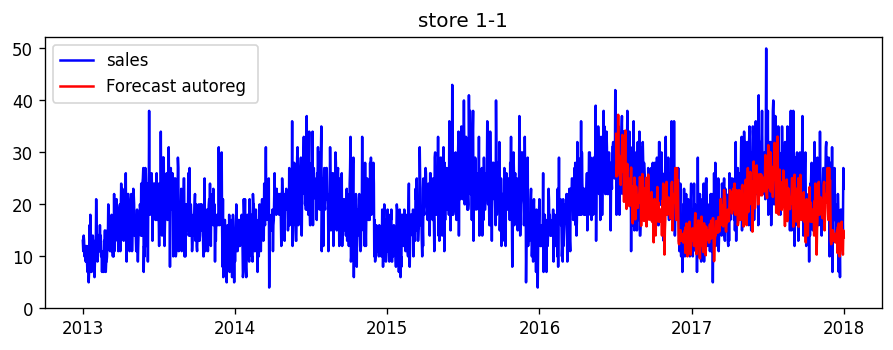

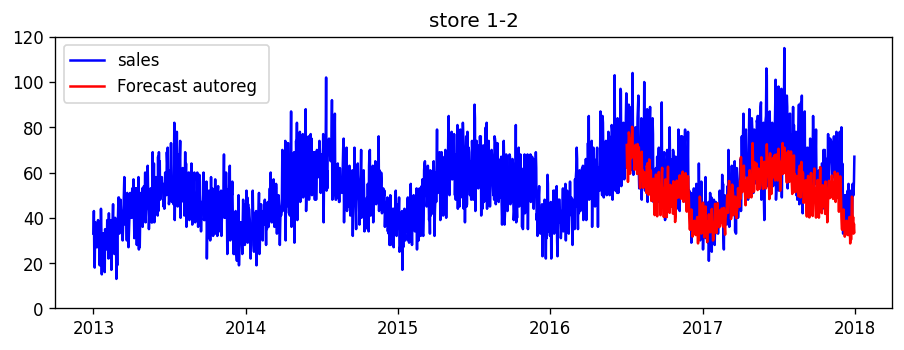

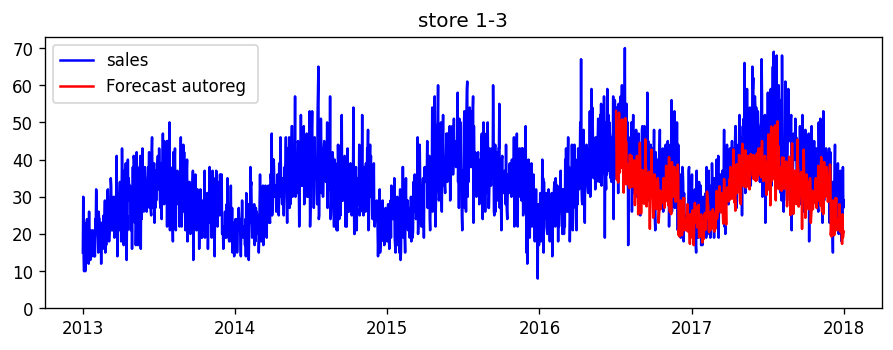

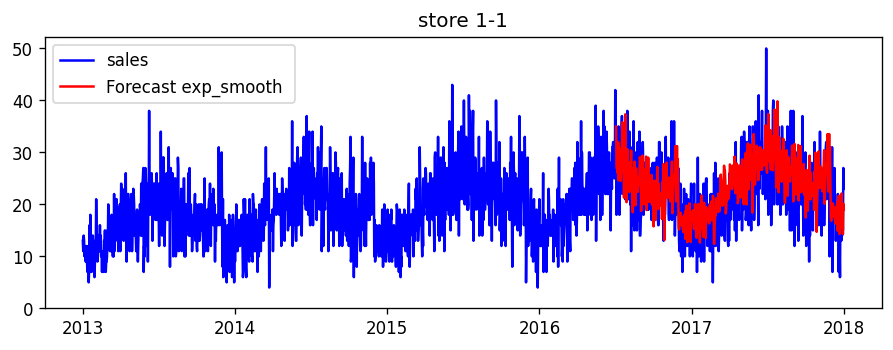

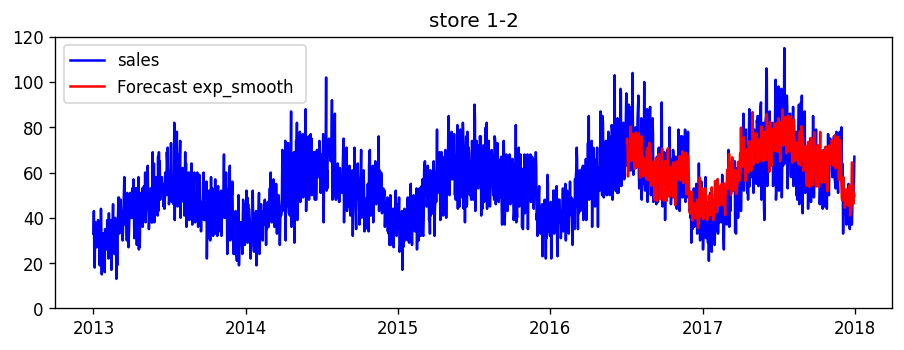

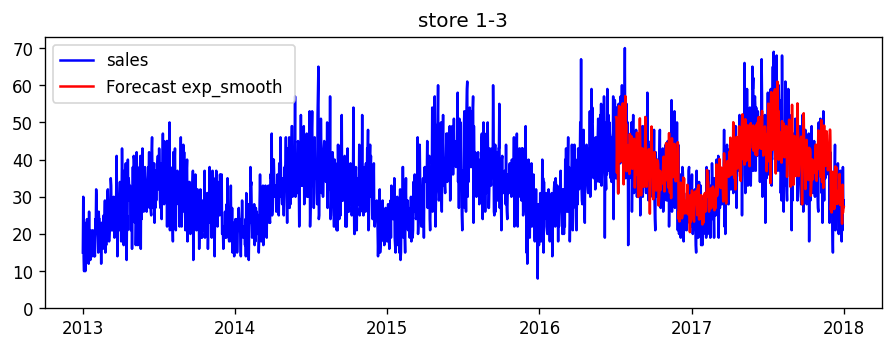

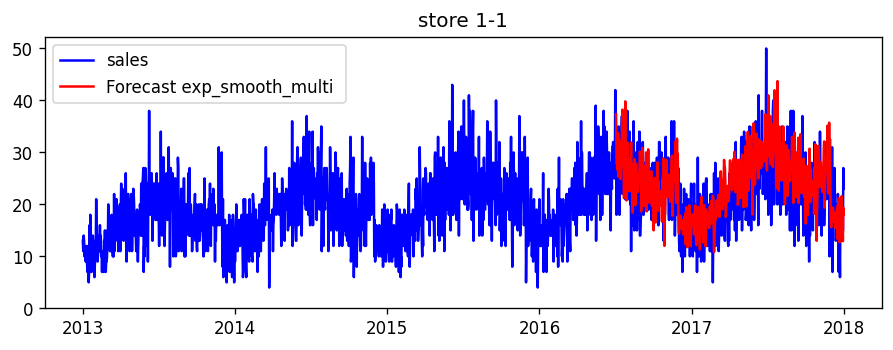

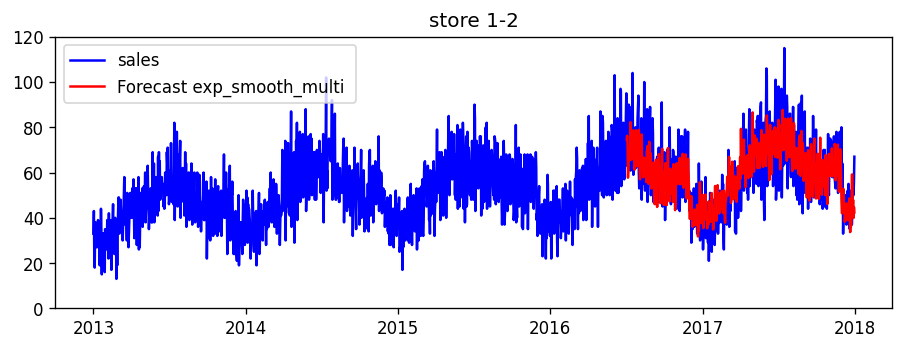

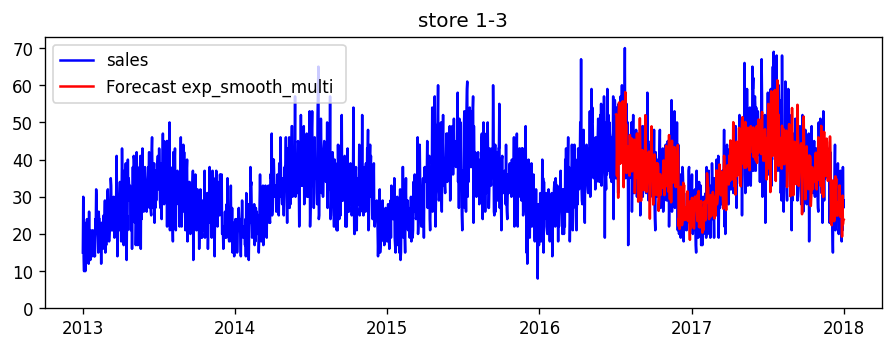

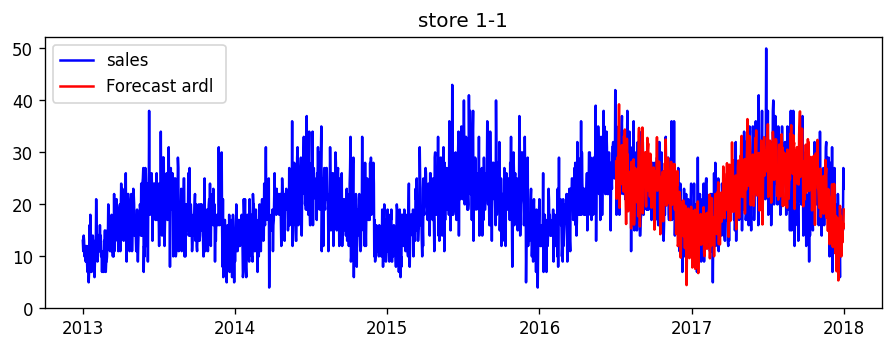

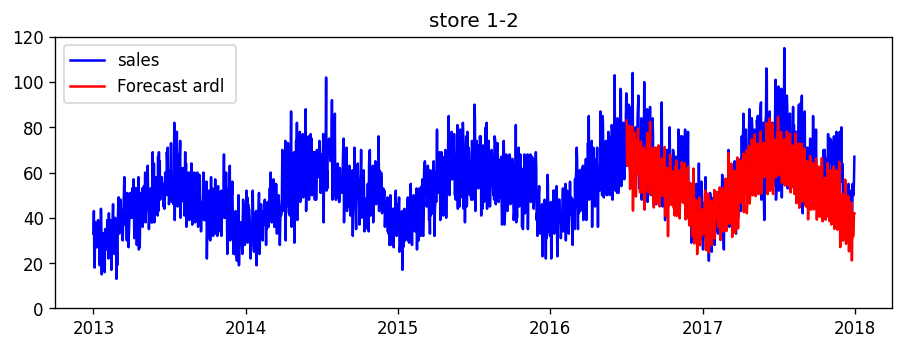

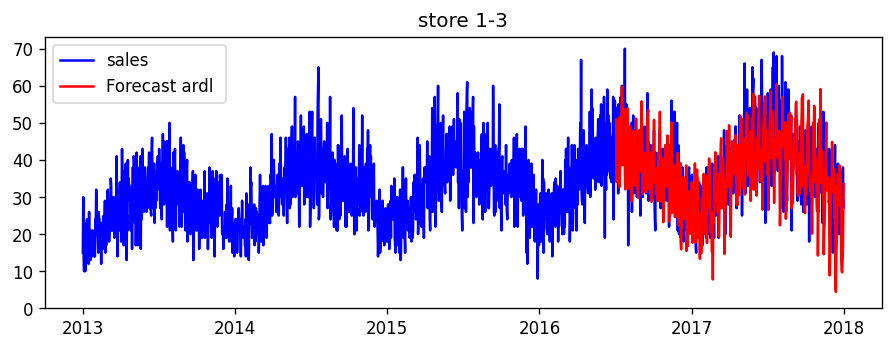

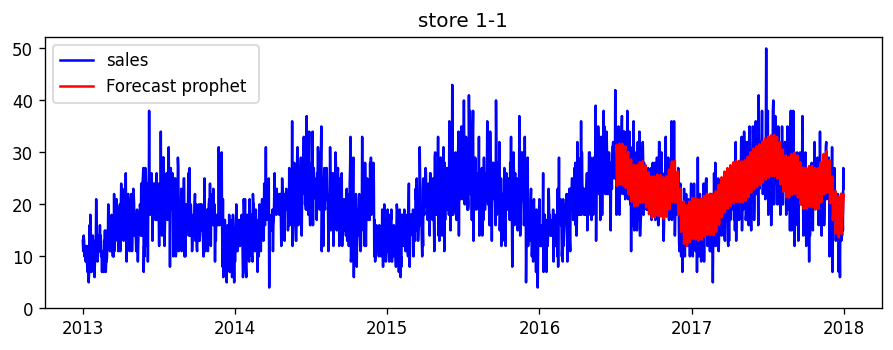

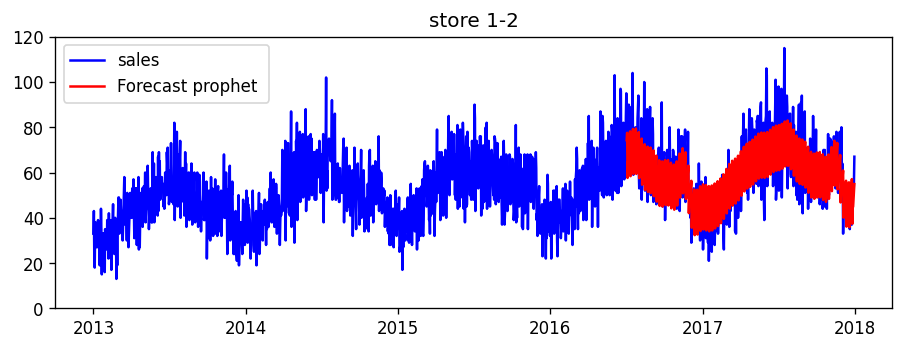

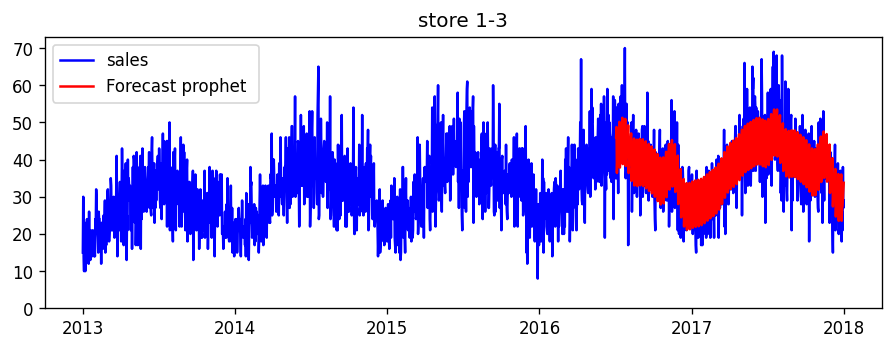

In [73]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

for forecast in store_sales.columns[2:]:
    fcastplotter(forecast)


In [68]:
from beepy import beep
beep()